In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import scipy.ndimage
import time
%matplotlib inline

def slope_filter(z,dx,dy,idegrees=False):
    """
    Filter kernal to calculate ArcGIS slope
    Call from scipy.ndimage.filters.generic_filter
        
    Iput:
        z - Raster of elevation values
        dx, dy - Spacing in x and y directions
        idegrees [optional] - when True, converts returned slope to degrees
        
    Returns:
        s - Raster of slopes in fraction (rise/run)
        
    Use the mode option in generic_filter to treat edges
    Suggest mode='nearest'
        
    See Garrard "Geoprocessing with Python", p. 256.
    Horn (1981), cited in Burrough, Macdonald, and Lloyd (2015), equations 10.9 and 10.10
    """
    dzdx=((z[2]+2.*z[5]+z[8])-(z[0]+2.*z[3]+z[6]))/(8.*dx)
    dzdy=((z[6]+2.*z[7]+z[8])-(z[0]+2.*z[1]+z[2]))/(8.*dy)
    # slope in fraction (rise over run)
    s = (dzdx**2.+dzdy**2.)**(0.5)
    if(idegrees):
        s = np.degrees(np.arctan(s))
    return s

def slope_dir_filter(z,dx,dy):
    """
    Filter kernal to calculate ArcGIS slope direction
    Call from scipy.ndimage.filters.generic_filter with size=3
    
    Iput:
        z - Raster of elevation values
        dx, dy - Spacing in x and y directions
        
    Returns:
        az - Raster of slope directions in 0-360
    
    Horn (1981), cited in Burrough, Macdonald, and Lloyd (2015), equations 10.9 and 10.10
    """
    eps = 1e-6
    dzdx=((z[2]+2.*z[5]+z[8])-(z[0]+2.*z[3]+z[6]))/(8.*dx)
    dzdy=((z[6]+2.*z[7]+z[8])-(z[0]+2.*z[1]+z[2]))/(8.*dy)
    # azimuth in geographic notation
    # this will return a number even with zero slopes
    az=np.degrees( np.arctan2(dzdx,dzdy))
    az = (az+360.)%360.
    return az

def tri_filter(z):
    """
    Filter kernal to calculate topographic roughness index
    Call from scipy.ndimage.filters.generic_filter with size=odd_number (typically 3)
    https://gis.stackexchange.com/questions/6056/calculating-topographic-ruggedness-index-in-arcgis-desktop
    Although this cites Rily et al. (1999), it produces numbers that match the post by whuber and does not
    agree with the numbers presented by Riley et al.
    
    Iput:
        z - Raster of elevation values
        
    Returns:
        r - Raster of roughness values
    
    """
    i=len(z)//2
    r = np.sqrt(np.sum((z-z[i])**2))
    return r

def mad_filter(z):
    """
    Filter kernal to mean absolute deviation topographic roughness index
    Call from scipy.ndimage.filters.generic_filter
    
    Iput:
        z - Raster of elevation values
        
    Returns:
        r - Raster of roughness values
    
    """
    i=len(z)//2
    r = np.mean(np.abs(z-z[i]))
    return r


In [2]:
# list of files to read
fdir_in = "F:/2017_Karen_Sandwich_maps/"
fdir_out = "F:/2017_Karen_Sandwich_maps/slopes_and_roughness/"
bnames = (\
          "2016-01-22_SandwichTNB_PT",\
          "2016-01-25_SandwichTNB",\
          "2016-02-11_SandwichTNB",\
          "2016-03-30_SandwichTNB_AS",\
          "2016-03-30_SandwichTNB_PT",\
          "2016-09-21_SandwichTNB",\
          "2017-01-09_SandwichTNB",\
          "2017-01-25_SandwichTNB",\
          "2017-02-14_SandwichTNB",\
          "2017-03-16_SandwichTNB",\
          "2017-04-28_SandwichTNB",\
          "2017-05-04_SandwichTNB",\
          "2017-09-18_SandwichTNB",\
          )
nf=len(bnames)
print("Processing {} files.".format(nf))
fnames=[]
for i in range(nf):
    fnames.append(bnames[i]+"_DEM_10cm_trimmed.tif")
    

Processing 13 files.


2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif
{'driver': 'GTiff', 'height': 10226, 'width': 11987, 'count': 1, 'dtype': 'float32', 'crs': CRS({'init': 'epsg:6348'}), 'transform': Affine(0.09999999999999806, 0.0, 376286.64299908397,
       0.0, -0.1, 4625440.8344103005)}


C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


Elapsed time: 2293.811865091324
Elapsed time: 2294.911279439926
2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif
{'driver': 'GTiff', 'height': 10156, 'width': 11420, 'count': 1, 'dtype': 'float32', 'crs': CRS({'init': 'epsg:6348'}), 'transform': Affine(0.10000000000000205, 0.0, 376287.14850415837,
       0.0, -0.1, 4625434.75106331)}
Elapsed time: 2205.3239262104034
Elapsed time: 2206.4275889396667
2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif
{'driver': 'GTiff', 'height': 10204, 'width': 11673, 'count': 1, 'dtype': 'float32', 'crs': CRS({'init': 'epsg:6348'}), 'transform': Affine(0.10000000000000099, 0.0, 376296.13149943855,
       0.0, -0.09999999999998174, 4625448.832959766)}
Elapsed time: 2242.999901533127
Elapsed time: 2244.2254796028137
2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif
{'driver': 'GTiff', 'height': 9858, 'width': 11504, 'count': 1, 'dtype': 'float32', 'crs': CRS({'init': 'epsg:6348'}), 'transform': Affine(0.09999999999999899, 0.0, 376292.3872081661,
       0.0, -0.10000000

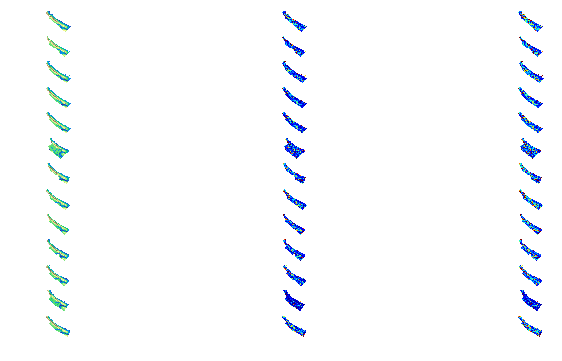

In [3]:
dx = .1
dy = .1
isub = 0
# declare a plot size
plt.subplots(figsize=(12,6))

for i in range(nf) :
    fn = bnames[i]+"_DEM_10cm_trimmed.tif"
    fn_slope = bnames[i]+"_slope.tif"
    fn_aspect = bnames[i]+"_aspect.tif"
    fn_tri = bnames[i]+"_tri.tif"
    fn_range = bnames[i]+"_range.tif"
    print( fn )
    
    tstart = time.time()
    with rasterio.open(fdir_in+fn) as src:
        z = src.read(1)
        z[z <= -99]=np.nan
        ysize, xsize = np.shape(z)
        profile = {'driver': 'GTiff', 'height': ysize, 'width': xsize, 'count': 1,\
           'dtype': 'float32', 'crs':src.crs, 'transform': src.transform}
        print(profile)
        src.close()
    
    s=scipy.ndimage.filters.generic_filter(z,slope_filter,size=3,mode='nearest',extra_arguments=(dx,dy))
    az = scipy.ndimage.filters.generic_filter(z,slope_dir_filter,size=3,mode='nearest',extra_arguments=(dx,dy))
    tri = scipy.ndimage.filters.generic_filter(z,tri_filter,size=3,mode='nearest')
    ptp = scipy.ndimage.filters.generic_filter(z,np.ptp,size=3,mode='nearest')
    
    # write the tiff files
    with rasterio.open(fdir_out+fn_slope, 'w', **profile) as dst:
        dst.write(s,1)
        dst.close()
    
    with rasterio.open(fdir_out+fn_aspect, 'w', **profile) as dst:
        dst.write(az,1)
        dst.close()
    
    with rasterio.open(fdir_out+fn_tri, 'w', **profile) as dst:
        dst.write(tri,1)
        dst.close()
        
    with rasterio.open(fdir_out+fn_range, 'w', **profile) as dst:
        dst.write(ptp,1)
        dst.close()
  
    print("Elapsed time:",time.time()-tstart)
    
    # small plots of elevation
    plt.subplot(nf,3,isub+1);
    plt.axis('off');plt.imshow(z,cmap=plt.cm.terrain,vmin=-2,vmax=8)
    plt.subplot(nf,3,isub+2);
    plt.axis('off');plt.imshow(s,cmap=plt.cm.jet,vmin=0.,vmax=.5)
    plt.subplot(nf,3,isub+3);
    plt.axis('off');plt.imshow(ptp,cmap=plt.cm.jet,vmin=0.,vmax=.1)
                   
    isub += 3
    
    print("Elapsed time:",time.time()-tstart)
